In [1]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold


from statsmodels.tsa.deterministic import DeterministicProcess

print('hello world')

hello world


In [2]:
df_origin = pd.read_csv('open/train.csv')

train_df = pd.read_csv('open/train.csv')
test_df = pd.read_csv('open/test.csv')
sub_df = pd.read_csv('open/sample_submission.csv')

print('Number of Data for training : {col}\n Number of Variables : {row}'
      .format(col = train_df.shape[0], row = train_df.shape[1]))

Number of Data for training : 1095
 Number of Variables : 13


주말 / 평일 구분 (Column : days_of_week)

In [3]:
train_df.loc[[611,612,613,614,615]] # 2019-09-07 자료가 없어...

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
611,2019-09-04,22.7,22.8,25.5,21.2,6.0,3.0,89.0,1.1,8.5,2.5,4.5,27168
612,2019-09-05,36.4,23.0,27.6,21.5,9.0,6.0,91.4,1.5,11.6,2.0,5.0,33929
613,2019-09-06,2.4,25.3,29.1,21.6,13.0,8.0,79.8,0.4,3.1,2.1,3.4,16631
614,2019-09-08,0.0,24.7,27.3,22.9,NaN,NaN,76.9,1.4,11.0,1.9,4.8,52055
615,2019-09-09,0.0,25.1,28.0,22.4,35.0,26.0,74.3,2.0,15.7,1.7,3.6,68370


In [4]:
# 2018.01.01 ~ 2020.12.31 (NaN of 2019.09.07 sat ;;;;;)
# 
new_row = pd.DataFrame(train_df.loc[[613]], columns = train_df.columns)

train_df = pd.concat([train_df.iloc[:613], new_row, train_df.iloc[613:]], ignore_index = True)

train_df.loc[614,'date'] = '2019-09-07' 


print(train_df.loc[[612,613,614,615]])
len(train_df)

           date  precipitation  temp_mean  temp_highest  temp_lowest  PM10  \
612  2019-09-05           36.4       23.0          27.6         21.5   9.0   
613  2019-09-06            2.4       25.3          29.1         21.6  13.0   
614  2019-09-07            2.4       25.3          29.1         21.6  13.0   
615  2019-09-08            0.0       24.7          27.3         22.9   NaN   

     PM2.5  humidity  sunshine_sum  sunshine_rate  wind_mean  wind_max  rental  
612    6.0      91.4           1.5           11.6        2.0       5.0   33929  
613    8.0      79.8           0.4            3.1        2.1       3.4   16631  
614    8.0      79.8           0.4            3.1        2.1       3.4   16631  
615    NaN      76.9           1.4           11.0        1.9       4.8   52055  


1096

In [5]:
# To distinguish weekend and weekday

# The name of new index is "days_of_week" 
# [0:Mon ~ Fri, 1:Sat, 1:Sun]

df_week = [] # List for df column "days of week"

L1 = train_df.shape[0] // 7  # 1096 // 7
L2 = train_df.shape[0] % 7  # 1096 // 7

#week = [0, 1, 2, 3, 4, 5, 6]
week = [0, 0, 0, 0, 0, 1, 1] # weekday / weekend

for i in range(0,L1,1):
    df_week.extend(week)

for i in range(0,L2,1):
    df_week.append(0)

print(len(df_week))


# test_df
t_df_week = []

t_L1 = test_df.shape[0] // 7
t_L2 = test_df.shape[0] % 7

t_week = [0, 1, 1, 0, 0, 0, 0]

for i in range(0, t_L1, 1):
    t_df_week.extend(week)

for i in range(0, t_L2, 1):
    t_df_week.append(0)

1096


In [6]:
# Appended New Col "days of week"
train_df['days_of_week'] = df_week

test_df['days_of_week'] = t_df_week

코드공유에서 가져온 Year / Month / Day 구분

In [7]:
year = []
month = []
day = [] 

for date in train_df["date"] :
    y = date.split('-')[0]
    m = date.split('-')[1]
    d = date.split('-')[2]
    
    year.append(y)
    month.append(m)
    day.append(d)

train_df["year"] = year 
train_df["month"] = month 
train_df["day"] = day

year = []
month = []
day = [] 

for date in test_df["date"] :
    y = date.split('-')[0]
    m = date.split('-')[1]
    d = date.split('-')[2]
    
    year.append(y)
    month.append(m)
    day.append(d)

test_df["year"] = year 
test_df["month"] = month 
test_df["day"] = day

In [8]:
365*2

730

Sunshine_rate을 이용하여 Sunshine_sum의 NaN을 선형 회귀로 구하기

In [9]:
nan_list_ss = train_df['sunshine_sum'][train_df['sunshine_sum'].isnull()].index
print(nan_list_ss)

t_nan_list_ss = test_df['sunshine_sum'][test_df['sunshine_sum'].isnull()].index
print(t_nan_list_ss)

Int64Index([17, 25, 45, 187, 604], dtype='int64')
Int64Index([6], dtype='int64')


In [10]:
train_df['sunshine_rate'].loc[nan_list_ss].values.reshape(-1,1) 
# 사실 train 데이터에서는 sunshine_sum이 Nan인 날은 전부 sunshine_rate가 0이라 걍 0으로 채워도 될거같음
# 그리고 test 데이터는 sunshine_sum Nan이 하나밖에없어서 큰 영향을 안줄듯
# 근데 이미 다 작성해놔서 걍 안지우고 넣어둠 ㅎㅎ..

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

               sunshine_rate  sunshine_sum
sunshine_rate       1.000000      0.958364
sunshine_sum        0.958364      1.000000


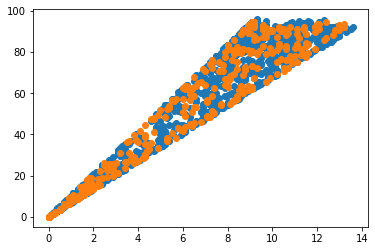

In [11]:
print(train_df[['sunshine_rate', 'sunshine_sum']].corr(method='pearson')) # Pearson Correlation

a = train_df['sunshine_sum'].dropna()
b = train_df['sunshine_rate'].drop(nan_list_ss)
a.isnull().sum()
b.isnull().sum()

t_a = test_df['sunshine_sum'].dropna()
t_b = test_df['sunshine_rate'].drop(t_nan_list_ss)
t_a.isnull().sum()
t_b.isnull().sum()

plt.plot(a,b, 'o')
plt.plot(t_a,t_b, 'o')

In [12]:
a = a.values.reshape(-1,1) # a is sunshine_sum
b = b.values.reshape(-1,1) # b is sunshine_rate

t_a = t_a.values.reshape(-1, 1)
t_b = t_b.values.reshape(-1, 1)

In [13]:
line_fitter = LinearRegression() # 선형회귀 이용하여 SS의 Nan 값 예측

line_fitter.fit(b, a) # predict a(sum) through b(rate) 
pred_ss = line_fitter.predict(train_df['sunshine_rate'].loc[nan_list_ss].values.reshape(-1, 1))
predd_ss = list(pred_ss)

t_pred_ss = line_fitter.predict(test_df['sunshine_rate'].loc[t_nan_list_ss].values.reshape(-1, 1))
t_pred_ss = list(t_pred_ss)

In [14]:
train_df["PM10"] = train_df["PM10"].fillna(train_df["PM10"].mean())
train_df["PM2.5"] = train_df["PM2.5"].fillna(train_df["PM2.5"].mean())
train_df["sunshine_sum"] = train_df["sunshine_sum"].fillna(0) # NaN값은  = 2  << 이런식으로 안들어가서
# 일단 0으로 다 채운다음에 선형회귀로 구한 값 입력

for i, j in zip(nan_list_ss, range(0,len(nan_list_ss),1)):
    train_df['sunshine_sum'].loc[i] = float(pred_ss[j])

for ii, jj in zip(t_nan_list_ss, range(0, len(t_nan_list_ss), 1)):
    test_df['sunshine_sum'].loc[ii] = float(t_pred_ss[jj])


C:\Users\Admin\AppData\Local\Temp\ipykernel_20928\4041030387.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['sunshine_sum'].loc[i] = float(pred_ss[j])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20928\4041030387.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['sunshine_sum'].loc[ii] = float(t_pred_ss[jj])


In [15]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
days_of_week       0
year               0
month              0
day                0
dtype: int64
date               0
precipitation    205
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       0
sunshine_rate      0
wind_mean          0
wind_max           0
days_of_week       0
year               0
month              0
day                0
dtype: int64


In [16]:
print(train_df['sunshine_sum'].loc[nan_list_ss])
print(test_df['sunshine_sum'].loc[t_nan_list_ss])

# 다 채움 근데 0으로 하는게 더 나을거같은 생각이 계속 듬

17     0.188313
25     0.188313
45     0.188313
187    0.188313
604    0.188313
Name: sunshine_sum, dtype: float64
6    0.188313
Name: sunshine_sum, dtype: float64


Predict Precipitation Using Linear Regression

In [17]:
nan_list_pp= train_df['precipitation'][train_df['precipitation'].isnull()].index
print(nan_list_pp)

pp = train_df['precipitation'].dropna()
srss = train_df[['sunshine_rate','sunshine_sum','month']].drop(nan_list_pp)

t_nan_list_pp = test_df['precipitation'][train_df['precipitation'].isnull()].index
print(t_nan_list_pp)

t_pp = test_df['precipitation'].dropna()
t_srss = test_df[['sunshine_rate','sunshine_sum','month']].drop(t_nan_list_pp)

Int64Index([   0,    1,    2,    3,    4,    5,    6,   10,   13,   16,
            ...
            1079, 1080, 1083, 1084, 1085, 1086, 1088, 1089, 1090, 1094],
           dtype='int64', length=678)
Int64Index([  0,   1,   2,   3,   4,   5,   6,  10,  13,  16,
            ...
            355, 356, 357, 358, 359, 360, 361, 362, 363, 364],
           dtype='int64', length=237)


In [18]:
scaler = MinMaxScaler()

scaler.fit(srss)

MinMaxScaler()

In [19]:
scaled_srss = scaler.transform(srss)

In [20]:
line_fitter.fit(scaled_srss, pp)

LinearRegression()

In [21]:
#pp_sol_Nan = line_fitter.predict(scaler.transform(new_df[['sunshine_rate','sunshine_sum','month']].loc[PP_list_Nan].values))
pred_pp = line_fitter.predict(scaler.transform(train_df[['sunshine_rate','sunshine_sum','month']].loc[nan_list_pp].values))
pred_pp = list(pred_pp)


t_pred_pp = list(line_fitter.predict(scaler.transform(test_df[['sunshine_rate','sunshine_sum','month']].loc[t_nan_list_pp].values)))


# very very weird
# Minus precipitation? >> Evaporation?

print(pred_pp)
print(t_pred_pp)

print(type(t_pred_pp))
len(t_pred_pp)

[-4.382438142792246, -3.49865785451097, -4.894634487744824, 0.34462034878139924, -4.010854199463552, -5.320667908595109, 7.090848881573964, -4.964940688556769, 1.7495743976550848, 3.548848420798345, -4.822230178943574, 2.5630484851244173, -3.6144361172046686, -5.388876001417739, -4.962842580567457, -3.700599041306969, 13.750398742364299, -5.033148781379403, -2.098485005298496, -4.835988794244617, -4.712955513899665, -3.9629083195917545, -4.586101727576825, -4.869424638813911, -4.246231230828844, -4.65640792838877, -4.529554142065926, 9.747346656079726, 3.4292496521267513, -2.469693238626462, 7.594443520887439, 14.140898210655976, -5.150649442061685, -3.754672808827827, -0.15822287053062212, 4.71632733031743, -2.247699112561488, -5.220955642873626, -0.6614417998433737, -3.784288147419229, -5.7558880187670844, 14.243433605948562, -5.308840964964514, -5.630756630432831, 4.943478366044344, -0.3708638709550378, -3.8790527771606342, 0.4653462474551713, 2.176359238506823, -0.19643991476112888

c:\Users\Admin\anaconda3\envs\lftest\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
c:\Users\Admin\anaconda3\envs\lftest\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


237

In [22]:
train_df['precipitation'] = train_df['precipitation'].fillna(0)

for i, j in zip(nan_list_pp, range(0,len(pred_pp),1)):
    train_df['precipitation'].loc[i] = float(pred_pp[j])



test_df['precipitation'] = test_df['precipitation'].fillna(0)


for ii, jj in zip(t_nan_list_pp, range(0, len(t_pred_pp), 1)):
    test_df['precipitation'].loc[ii] = float(t_pred_pp[jj])

C:\Users\Admin\AppData\Local\Temp\ipykernel_20928\3578690188.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['precipitation'].loc[i] = float(pred_pp[j])
C:\Users\Admin\AppData\Local\Temp\ipykernel_20928\3578690188.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['precipitation'].loc[ii] = float(t_pred_pp[jj])


In [23]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

date             0
precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
rental           0
days_of_week     0
year             0
month            0
day              0
dtype: int64
date             0
precipitation    0
temp_mean        0
temp_highest     0
temp_lowest      0
PM10             0
PM2.5            0
humidity         0
sunshine_sum     0
sunshine_rate    0
wind_mean        0
wind_max         0
days_of_week     0
year             0
month            0
day              0
dtype: int64


In [24]:
train_df1 = train_df.head(730)
test_df1 = train_df.tail(train_df.shape[0]-730)

test_df1

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental,days_of_week,year,month,day
730,2020-01-01,0.100000,-2.2,0.3,-6.5,34.0,24.0,64.4,0.8,8.3,0.6,2.6,16236,0,2020,01,01
731,2020-01-02,13.852934,1.0,3.8,-0.7,59.0,45.0,65.4,0.0,0.0,1.2,4.0,28890,0,2020,01,02
732,2020-01-03,-5.320668,-0.1,4.6,-3.4,66.0,48.0,56.9,8.8,90.7,1.7,3.5,30809,0,2020,01,03
733,2020-01-04,-3.355947,1.2,6.1,-2.8,56.0,41.0,50.8,7.9,81.4,1.9,4.5,25709,1,2020,01,04
734,2020-01-05,-1.620100,1.3,6.6,-3.2,53.0,39.0,45.6,7.1,73.2,1.1,2.9,23206,1,2020,01,05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1091,2020-12-27,0.000000,5.8,10.0,1.4,70.0,42.0,62.9,5.9,61.5,1.8,2.8,37103,1,2020,12,27
1092,2020-12-28,1.300000,6.7,11.4,4.2,66.0,44.0,72.1,8.0,83.3,1.4,3.1,46912,0,2020,12,28
1093,2020-12-29,0.200000,0.1,4.3,-6.2,69.0,46.0,70.8,0.0,0.0,2.9,6.1,35747,0,2020,12,29
1094,2020-12-30,-0.086944,-10.9,-6.2,-12.9,39.0,15.0,55.5,8.3,86.5,4.1,6.2,22488,0,2020,12,30


# 2018 ~ 2019, 2019 ~ 2020년도 각 월별 증가량 추이

In [25]:
train_2018 = train_df[train_df['year'] == '2018']
train_2019 = train_df[train_df['year'] == '2019']
train_2020 = train_df[train_df['year'] == '2020']


s2018_01 = train_2018[train_2018['month'] == '01' ]['rental'].values.sum()
s2019_01 = train_2019[train_2019['month'] == '01' ]['rental'].values.sum()
s2020_01 = train_2020[train_2020['month'] == '01' ]['rental'].values.sum()

s2018_02 = train_2018[train_2018['month'] == '02' ]['rental'].values.sum()
s2019_02 = train_2019[train_2019['month'] == '02' ]['rental'].values.sum()
s2020_02 = train_2020[train_2020['month'] == '02' ]['rental'].values.sum()

s2018_03 = train_2018[train_2018['month'] == '03' ]['rental'].values.sum()
s2019_03 = train_2019[train_2019['month'] == '03' ]['rental'].values.sum()
s2020_03 = train_2020[train_2020['month'] == '03' ]['rental'].values.sum()

s2018_04 = train_2018[train_2018['month'] == '04' ]['rental'].values.sum()
s2019_04 = train_2019[train_2019['month'] == '04' ]['rental'].values.sum()
s2020_04 = train_2020[train_2020['month'] == '04' ]['rental'].values.sum()

s2018_05 = train_2018[train_2018['month'] == '05' ]['rental'].values.sum()
s2019_05 = train_2019[train_2019['month'] == '05' ]['rental'].values.sum()
s2020_05 = train_2020[train_2020['month'] == '05' ]['rental'].values.sum()

s2018_06 = train_2018[train_2018['month'] == '06' ]['rental'].values.sum()
s2019_06 = train_2019[train_2019['month'] == '06' ]['rental'].values.sum()
s2020_06 = train_2020[train_2020['month'] == '06' ]['rental'].values.sum()

s2018_07 = train_2018[train_2018['month'] == '07' ]['rental'].values.sum()
s2019_07 = train_2019[train_2019['month'] == '07' ]['rental'].values.sum()
s2020_07 = train_2020[train_2020['month'] == '07' ]['rental'].values.sum()

s2018_08 = train_2018[train_2018['month'] == '08' ]['rental'].values.sum()
s2019_08 = train_2019[train_2019['month'] == '08' ]['rental'].values.sum()
s2020_08 = train_2020[train_2020['month'] == '08' ]['rental'].values.sum()

s2018_09 = train_2018[train_2018['month'] == '09' ]['rental'].values.sum()
s2019_09 = train_2019[train_2019['month'] == '09' ]['rental'].values.sum()
s2020_09 = train_2020[train_2020['month'] == '09' ]['rental'].values.sum()

s2018_10 = train_2018[train_2018['month'] == '10' ]['rental'].values.sum()
s2019_10 = train_2019[train_2019['month'] == '10' ]['rental'].values.sum()
s2020_10 = train_2020[train_2020['month'] == '10' ]['rental'].values.sum()

s2018_11 = train_2018[train_2018['month'] == '11' ]['rental'].values.sum()
s2019_11 = train_2019[train_2019['month'] == '11' ]['rental'].values.sum()
s2020_11 = train_2020[train_2020['month'] == '11' ]['rental'].values.sum()

s2018_12 = train_2018[train_2018['month'] == '12' ]['rental'].values.sum()
s2019_12 = train_2019[train_2019['month'] == '12' ]['rental'].values.sum()
s2020_12 = train_2020[train_2020['month'] == '12' ]['rental'].values.sum()

s01 = [s2018_01, s2019_01]
s02 = [s2018_02, s2019_02]
s03 = [s2018_03, s2019_03]
s04 = [s2018_04, s2019_04]
s05 = [s2018_05, s2019_05]
s06 = [s2018_06, s2019_06]
s07 = [s2018_07, s2019_07]
s08 = [s2018_08, s2019_08]
s09 = [s2018_09, s2019_09]
s10 = [s2018_10, s2019_10]
s11 = [s2018_11, s2019_11]
s12 = [s2018_12, s2019_12]

[500822, 882078]


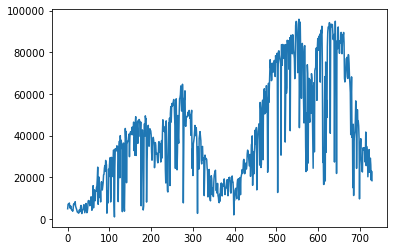

In [26]:
print(s12)
plt.plot(train_df1['rental'])

In [27]:
curve_fit01 = LinearRegression()
curve_fit02 = LinearRegression()
curve_fit03 = LinearRegression()
curve_fit04 = LinearRegression()
curve_fit05 = LinearRegression()
curve_fit06 = LinearRegression()
curve_fit07 = LinearRegression()
curve_fit08 = LinearRegression()
curve_fit09 = LinearRegression()
curve_fit10 = LinearRegression()
curve_fit11 = LinearRegression()
curve_fit12 = LinearRegression()



curve_fit01.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s01).reshape(-1, 1))
curve_fit02.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s02).reshape(-1, 1))
curve_fit03.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s03).reshape(-1, 1))
curve_fit04.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s04).reshape(-1, 1))
curve_fit05.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s05).reshape(-1, 1))
curve_fit06.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s06).reshape(-1, 1))
curve_fit07.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s07).reshape(-1, 1))
curve_fit08.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s08).reshape(-1, 1))
curve_fit09.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s09).reshape(-1, 1))
curve_fit10.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s10).reshape(-1, 1))
curve_fit11.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s11).reshape(-1, 1))
curve_fit12.fit(np.array([2018, 2019]).reshape(-1, 1) , np.array(s12).reshape(-1, 1))

LinearRegression()

In [28]:
pred_01 = curve_fit01.predict(np.array([2020]).reshape(-1, 1))
pred_02 = curve_fit02.predict(np.array([2020]).reshape(-1, 1))
pred_03 = curve_fit03.predict(np.array([2020]).reshape(-1, 1))
pred_04 = curve_fit04.predict(np.array([2020]).reshape(-1, 1))
pred_05 = curve_fit05.predict(np.array([2020]).reshape(-1, 1))
pred_06 = curve_fit06.predict(np.array([2020]).reshape(-1, 1))
pred_07 = curve_fit07.predict(np.array([2020]).reshape(-1, 1))
pred_08 = curve_fit08.predict(np.array([2020]).reshape(-1, 1))
pred_09 = curve_fit09.predict(np.array([2020]).reshape(-1, 1))
pred_10 = curve_fit10.predict(np.array([2020]).reshape(-1, 1))
pred_11 = curve_fit11.predict(np.array([2020]).reshape(-1, 1))
pred_12 = curve_fit12.predict(np.array([2020]).reshape(-1, 1))

print(pred_01)
print(pred_02)
print(pred_03)
print(pred_04)
print(pred_05)
print(pred_06)
print(pred_07)
print(pred_08)
print(pred_09)
print(pred_10)
print(pred_11)
print(s12, pred_12)

r01 = pred_01/s01[1]
r02 = pred_02/s02[1]
r03 = pred_03/s03[1]
r04 = pred_04/s04[1]
r05 = pred_05/s05[1]
r06 = pred_06/s06[1]
r07 = pred_07/s07[1]
r08 = pred_08/s08[1]
r09 = pred_09/s09[1]
r10 = pred_10/s10[1]
r11 = pred_11/s11[1]
r12 = pred_12/s12[1] 

[[826779.]]
[[774345.]]
[[1346977.]]
[[2248115.]]
[[3500181.]]
[[3380635.]]
[[3228157.]]
[[3164863.]]
[[2753713.]]
[[3452181.]]
[[2113006.]]
[500822, 882078] [[1263334.]]


In [29]:
s2020_12 = train_2020[train_2020['month'] == '12' ]['rental'].values.sum()
print(s2020_12)

1196309


In [30]:
def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

In [31]:
x = train_df1.drop(['date','rental'], axis = 1)
y = train_df1['rental']

X = test_df1.drop(['date','rental'], axis =1)
Y = test_df1['rental']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, shuffle = False)

In [32]:
Y.shape[0]

366

In [33]:
acc_history1 = []
acc_history2 = []
acc_history3 = []


model1 = RandomForestRegressor()
model1.fit(x_train, y_train)

y1_pred = model1.predict(x_test)
acc_history1.append(NMAE(y_test, y1_pred))

model2 = GradientBoostingRegressor()
model2.fit(x_train, y_train)

y2_pred = model2.predict(x_test)
acc_history2.append(NMAE(y_test, y2_pred))


model3 = LinearRegression()
model3.fit(x_train, y_train)

y3_pred = model3.predict(x_test)
acc_history3.append(NMAE(y_test, y3_pred))

print(np.mean(acc_history1), np.mean(acc_history2), np.mean(acc_history3))

0.274448013398813 0.22747528498725506 0.3461064447365569


0.3810179772866184


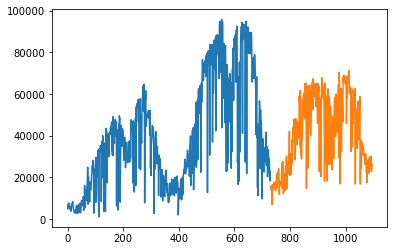

In [34]:
pred = model2.predict(X)
print(NMAE(Y.values, pred))
plt.plot(y)
plt.plot(X.index,pred)

In [61]:
pred_test = model2.predict(X)

print('len pred_test', len(pred_test))
pred_test_r=[]

p01 = pred_test[0:30] * r01
p02 = pred_test[30:57] * r02
p03 = pred_test[57:88] * r03
p04 = pred_test[88:118] * r04
p05 = pred_test[118:149] * r05
p06 = pred_test[149:179] * r06
p07 = pred_test[179:210] * r07
p08 = pred_test[210:241] * r08
p09 = pred_test[241:271] * r09
p10 = pred_test[271:302] * r10
p11 = pred_test[302:332] * r11
p12 = pred_test[332:366] * r12

pred_test_r = np.concatenate([p01, p02, p03, p04, p05, p06, p07, p08, p09, p10, p11, p12], axis = 1)

pred_test_r_list = pred_test_r.flatten().tolist()

len pred_test 366


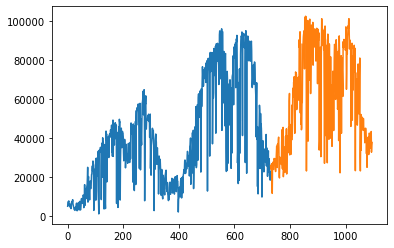

In [65]:
from matplotlib.lines import Line2D
plt.plot(y)
plt.plot(X.index,pred_test_r_list)
#plt.plot(X.index, Y.values)


x = np.array(train_df.drop(['date','rental'], axis =1))
y = train_df['rental']

kf = KFold(n_splits = 15, shuffle = False)

acc_history1 = []
acc_history2 = []


for train_index, test_index in kf.split(x):

    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model1 = RandomForestRegressor()
    model1.fit(x_train, y_train)

    y1_pred = model1.predict(x_test)
    acc_history1.append(NMAE(y_test, y1_pred))


    model2 = GradientBoostingRegressor()
    model2.fit(x_train, y_train)

    y2_pred = model2.predict(x_test)
    acc_history2.append(NMAE(y_test, y2_pred))

print(np.mean(acc_history1), np.mean(acc_history2))

test_data =test_df.drop(['date'], axis =1)


test_pred1 = model1.predict(test_data)

test_pred2 = model2.predict(test_data)

print(test_pred1)

print(test_pred2)

for i in range(0, len(test_pred2), 1) :
    sub_df['rental'].loc[i] = test_pred2[i]

sub_df.to_csv('/content/drive/MyDrive/2022DACON-bike-Hyeong/2022DACON-bike-Hyeong/open/sample_submission2.csv', index=False)


fig1 = plt.plot(test_pred2)

fig2 = plt.plot(train_df['rental'])

def NMAE(true, pred):
    score = np.mean(np.abs(true-pred) / true)
    return score

nmae_gbr = []
nmae_rf = []
nmae_lr = []

for i in range(0, 10, 1):

    train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.25, shuffle=True)

    reg = GradientBoostingRegressor()
    reg.fit(train_x, train_y)
    val_pred = reg.predict(val_x)
    nmae_gbr.append(NMAE(val_y, val_pred))


    regRF = RandomForestRegressor()
    regRF.fit(train_x, train_y)
    val_pred = regRF.predict(val_x)
    nmae_rf.append(NMAE(val_y, val_pred))
    
    regLR = LinearRegression()
    regLR.fit(train_x, train_y)
    val_pred = regLR.predict(val_x)
    nmae_lr.append(NMAE(val_y, val_pred))


plt.plot(range(0,10,1), nmae_gbr, label = 'GBR_precip')
plt.plot(range(0,10,1), nmae_rf, label = 'RF_precip')
plt.plot(range(0,10,1), nmae_lr, label = 'LR_precip' )
plt.legend()

gbr_precip = sum(nmae_gbr)/len(nmae_gbr)
rf_precip = sum(nmae_rf)/len(nmae_gbr)
lr_precip = sum(nmae_lr)/len(nmae_lr)

print(gbr_precip)
print(rf_precip)
print(lr_precip)

x1 = train_df.drop(['precipitation','date','rental'], axis=1)
y1 = train_df['rental']

nmae_gbr = []
nmae_rf = []
nmae_lr = []

for i in range(0, 10, 1):
   
    train_x, val_x, train_y, val_y = train_test_split(x, y, test_size = 0.25, shuffle=True)

    reg = GradientBoostingRegressor()
    reg.fit(train_x, train_y)
    val_pred = reg.predict(val_x)
    nmae_gbr.append(NMAE(val_y, val_pred))


    regRF = RandomForestRegressor()
    regRF.fit(train_x, train_y)
    val_pred = regRF.predict(val_x)
    nmae_rf.append(NMAE(val_y, val_pred))

    regLR = LinearRegression()
    regLR.fit(train_x, train_y)
    val_pred = regLR.predict(val_x)
    nmae_lr.append(NMAE(val_y, val_pred))
    

plt.plot(range(0,10,1), nmae_gbr, label = 'GBR_non_precip')
plt.plot(range(0,10,1), nmae_rf, label = 'RF_non_precip')
plt.plot(range(0,10,1), nmae_lr, label = 'LR_non_precip' )
plt.legend()

gbr_non_precip = sum(nmae_gbr)/len(nmae_gbr)
rf_non_precip = sum(nmae_rf)/len(nmae_gbr)
lr_non_precip = sum(nmae_lr)/len(nmae_lr)

print(gbr_non_precip)
print(rf_non_precip)
print(lr_non_precip)

print(gbr_non_precip)
print(rf_non_precip)

print(gbr_precip)
print(rf_precip)